**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
   лемматизация + CountVectorizer + KMeans

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'0.23.2'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
2557,"Как оказалось, почти 90% вегетарианцев отказываются от этой диеты в течение 6 месяцев после знакомства с ней. Никто не отрицает полезности натуральных продуктов, но люди не выдерживают питания без...",science
517,"Граната рядом с трассой. Черный копатель ""заминировал"" дорогу под Витебском\n\n8 декабря 2016 в 8:11\n\nЕлена Бегунова, СБ Беларусь Сегодня\n\nПроезжая недалеко от городского поселка Руба, водител...",incident


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# NOUN (существительное), VERB (глагол), ADJF (прилагательное)
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''


def tokenize_normalize(s):
    return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [7]:
data['ctext'] = data['text']\
                    .progress_apply(string_normalizer)\
                    .progress_apply(tokenize_normalize)

100%|██████████| 3196/3196 [01:13<00:00, 43.38it/s]


In [8]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 22123 слов


In [9]:
data['ctext'] = data['ctext'].apply(' '.join)

In [10]:
data.sample(10)

,text,tag,ctext
402,"миллионов долларов на изучение ""птичьего гриппа"" выделят в\nВеликобритании Представители британского Совета по медицинским исследованиям\nв среду, 30 ноября, заявили о намерении создать фонд разме...",health,миллион доллар изучение птичий грипп выделить великобритания представитель британский совет медицинский исследование среда ноябрь заявить намерение фонд размер миллион фунт миллион доллар кото...
3137,"О традициях финно-угорских и самодийских народов расскажет новый фильм\nНовости-online (Регион-Информ-Москва) О реализации программы ""Улучшение\nжилищных условий населения Ханты-Мансийского автоно...",culture,традиция финно-угорский народ рассказать новый фильм реализация программа улучшение жилищный условие население ханты-мансийский автономный округа югра год июльский заседание депутат окружный ...
1823,"Общая сумма ущерба от тайфуна «Лайонрок» в Приморском крае составляет 7 миллиардов рублей, об это сообщил губернатор региона Владимир Миклушевский.\n\n«Посчитана сумма ущерба, она составляет более...",incident,общий сумма ущерб тайфун приморский край составлять миллиард рубль сообщить губернатор регион владимир сумма ущерб составлять миллиард рубль миллиард самый большой сумма восстановление до...
741,"Балы и фестивали. Более 1,5 тысячи новогодних мероприятий ждет юных жителей Брестской области\n\n8 декабря 2016 в 11:18\n\nБЕЛТА\n\nБолее 1,5 тысячи новогодних мероприятий запланировано для юных ж...",tech,бал фестиваль тысяча новогодний мероприятие ждать юный житель брестский область декабрь тысяча новогодний мероприятие юный житель брестский область сообщить управление образование облисполко...
664,Грандиозная распродажа Hyundai Accent и Hyundai Creta!\n\n1 декабря 2016 в 9:00\n\n*На правах рекламы\n\nСегодня официально объявлена зима и открыт сезон предновогодних распродаж автомобилей Hyund...,reclama,грандиозный распродажа декабрь право реклама зима сезон предновогодний распродажа автомобиль популярный модель стать свой будущий владелец сезонный распродажа скидка любой компл...
1879,09:23 13 декабря 2016 2\n\nЭскиз стоит целое состояние Фото: Владимир Жабриков © URA.Ru\n\nРисунок Леонардо да Винчи стоимостью в 15 миллионов евро был случайно обнаружен в Париже.\n\nПачку рисунк...,culture,декабрь эскиз стоить целое состояние фото владимир рисунок леонардо винчи стоимость миллион евро быть париж пачка рисунок отец центральный франция март принести аукционный дом французски...
2459,В Уфе пройдет большой концерт с участием известных кубызистов республики.\n\n\n\nВ Башгосфилармонии в рамках проекта «Бессмертное наследие моего народа» состоится концерт «Магический кубыз». В муз...,culture,уфа пройти большой концерт участие известный республика рамка проект бессмертный наследие мой народ состояться концерт магический музыкальный представление принять участие коллектив республика...
1087,"Проведение ЧМ-2021 по биатлону в Тюмени зависит от WADA\n\n9 декабря 2016 в 9:47\n\nОлег Кошелев, Лозанна, ТАСС\n\nПроведение чемпионата мира 2021 года по биатлону в Тюмени зависит в том числе и о...",sport,проведение биатлон тюмень зависеть декабрь олег кошелев лозанна тасс проведение чемпионат мир год биатлон тюмень зависеть тот число решение всемирный антидопинговый агентство заниматься в...
909,"""Батареи плачут, коврики — золотые"". Жильцы хотят уволить председателя ТСЖ, но замену не найти\n\n1 декабря 2016 в 11:09\n\nЕлена Бычкова / Фото: Иван Яриванович / TUT.BY\n\nВ июле прошлого года ж...",realty,батарея плакать коврик золотой жилец хотеть председатель замена декабрь елена бычков фото иван июль прошлое год жилец дом улица гомель получить долгожданный ключ свой квартира создат...
320,"Вячеслав Малежик сегодня споет ""Вологду"" в ""Русском Доме"" (3)Вячеслав\nМалежик на Вологодчине не первый раз. И, по словам певца, вологодский\nкрай произвел на него сильное впечатление",culture,вячеслав спеть вологда русский дом вячеслав один раз слово певец вологодский край произвести сильный впечатление


##  Vectorizer

In [11]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = CountVectorizer(tokenizer=tokenizer, token_pattern=None).fit_transform(data['ctext'])

## кластеризируем

In [29]:
data['cluster'] = KMeans(n_clusters=12).fit(X).labels_
data['cluster'].drop_duplicates().count()

12

## тестируем

In [30]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,0,50,culture reclama tech sport woman
1,1,114,politics realty economics
2,2,319,science culture social reclama auto realty tech sport incident politics woman economics
3,3,2590,science culture social auto reclama realty tech sport incident health politics woman economics
4,4,1,economics
5,5,18,social auto sport woman economics
6,6,1,economics
7,7,1,sport
8,8,1,economics
9,9,88,science culture social reclama auto realty tech sport incident politics woman economics


<AxesSubplot:xlabel='cluster'>

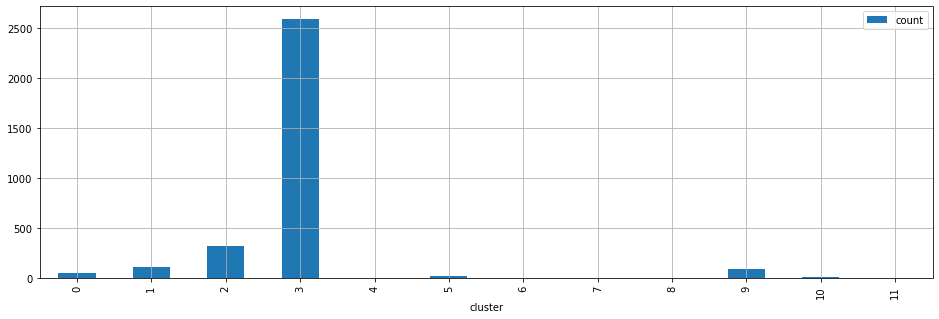

In [34]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [35]:
def print_cluster_samples(n,ns=5,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    top = [ t[:nt].replace('\n',' ') for t in data.query(f'cluster=={n}')['text'].sample(ns).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [36]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 9, элементов: 88, метки: "science culture social reclama auto realty tech sport incident politics woman economics" ]

"Свое дело". Владелец мобильного шиномонтажа: "Половина моих клиентов — женщины"  28 ноября 2016 в 9:46  Юлия Альгерчик / Фото: Дмитрий Брушко / AUTO.TUT.BY  «Кому нужны эти университеты, если с высшим образованием люди дворы подметают? Буду зарабатывать», — еще в школе решил минчанин Вадим и после  ...


Кто круче: тестируем УАЗ Патриот и десятилетний Nissan Patrol  28 ноября 2016 в 10:00  Иван Петренко, фото Павла Мурашко, AUTO.TUT.BY  Вопрос ребром: новый, гарантийный, но российский или 13-летний и с почти полумиллионным пробегом, но японский? Что выберете вы: обновленный в очередной раз УАЗ Патри ...


Архитектура Минска, современная физика и Гарри Поттер. В столице пройдут бесплатные лекции ученых  2 декабря 2016 в 16:05  AFISHA.TUT.BY  С 8 по 11 декабря в Минске пройдет вторая волна фестиваля премии «Просветитель». На четыре дня ученые вновь встретятся в